Prep

In [1]:
import functools
import itertools
import multiprocessing
import os
from typing import Mapping

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

import pandas as pd
pd.set_option('display.max_rows', 200)

from tqdm import tqdm
import getpass
import logging

logging.basicConfig(level=logging.ERROR)

In [2]:
import adapter_covid19
from adapter_covid19.data_structures import Scenario, ModelParams
from adapter_covid19.simulator import Simulator
from adapter_covid19.enums import Age10Y, Region
from adapter_covid19.lockdown import get_lockdown_factor, get_working_factor
from COVID19.model import Parameters, OccupationNetworkEnum

Initialize simulator

In [3]:
data_path = os.path.join(adapter_covid19.__path__[0], '../../tests/adapter_covid19/data')

simulator = Simulator(data_path)

Inialize scenarios

In [4]:
LOCKDOWN_PARAMETERS = {
    "quarantine_household_on_positive": 1,
    "quarantine_household_on_symptoms": 1,
    "self_quarantine_fraction": 0.8,
}

Run spread model once

In [5]:
import example_utils as utils

def set_occupation_params(params: Parameters, model, value: float):
    occupation_params = {
        f'lockdown_occupation_multiplier{on.name}': params.get_param(f'lockdown_occupation_multiplier{on.name}')
        for on in OccupationNetworkEnum
    }
    if not all(np.isclose(v, value) for v in occupation_params.values()):
        for on in OccupationNetworkEnum:
            model.update_running_params(f'lockdown_occupation_multiplier{on.name}', value)

def run_worker(populations: Mapping[Age10Y, int], lockdown_start: int, lockdown_end: int, end: int, slow_unlock: bool, data_path: str):
    population = 100_000
    params = utils.get_baseline_parameters()
    params.set_param( "n_total", population )
    for k, v in populations.items():
        params.set_param(k.value, v)

    sim = utils.get_simulation( params )

    sim.steps( lockdown_start )

    for k, v in LOCKDOWN_PARAMETERS.items():
        sim.env.model.update_running_params(k, v)
    lockdown_factor = get_lockdown_factor(lockdown=True, slow_unlock=slow_unlock, lockdown_exit_time=0, time=sim.timestep)
    occupation_factor = get_working_factor(data_path, lockdown_factor)
    set_occupation_params(params, sim.env.model, occupation_factor)
        
    sim.env.model.update_running_params("lockdown_on", 1)
    sim.steps( lockdown_end - lockdown_start)

    if not slow_unlock:
        sim.env.model.update_running_params("lockdown_on", 0)
    while sim.timestep < end:
        lockdown_factor = get_lockdown_factor(lockdown=False, slow_unlock=slow_unlock, lockdown_exit_time=lockdown_end, time=sim.timestep)
        occupation_factor = get_working_factor(data_path, lockdown_factor)
        set_occupation_params(params, sim.env.model, occupation_factor)
        sim.steps( min(end - sim.timestep, 10) )

    timeseries = pd.DataFrame( sim.results )
    ill_ratio = timeseries["n_symptoms"]  / population
    dead_ratio = timeseries["n_death"] / population
    quarantine_ratio = timeseries["n_quarantine"] / population
    data = {'ill_ratio': ill_ratio.to_dict(), 'dead_ratio': dead_ratio.to_dict(), 'quarantine_ratio': quarantine_ratio.to_dict()}
    return data
    

def get_ill_dead_ratio_from_spread_model(
    data_folder: str, lockdown_start: int = 0, lockdown_end:int = 0, end: int=50, slow_unlock: bool = False, reload: bool = False
):
    populations_df = pd.read_csv(os.path.join(data_folder, "populations.csv"))
    populations_by_region = {
        Region[k]: {Age10Y[kk]: vv for kk, vv in v.items()}
        for k, v in populations_df.set_index("region").T.to_dict().items()
    }
    file_name = f'spread_model_cache_{lockdown_start}_{lockdown_end}_{end}_{slow_unlock}.pkl'
    file_path = os.path.join(data_folder, file_name)
    if not os.path.exists(file_path) or reload:
        worker = functools.partial(
            run_worker, lockdown_start=lockdown_start, lockdown_end=lockdown_end, end=end, slow_unlock=slow_unlock, data_path=data_folder)
        with multiprocessing.Pool() as pool:
            data = pool.map(worker, [populations_by_region[r] for r in Region])
        keys = data[0].keys()
        data = {k: {t: {r: data[i][k][t] for i, r in enumerate(Region)} for t in range(end)} for k in keys}
        with open(file_path, 'wb') as f:
            pickle.dump(data, f)
    else:
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
    total_population_by_region = pd.DataFrame(populations_by_region).sum()
    pct_population_by_region = total_population_by_region / total_population_by_region.sum()
    seriess = {k: (pd.DataFrame(v).T * pct_population_by_region).sum(axis=1) for k, v in data.items()}
    df = pd.concat(seriess, axis=1)
    return data, df

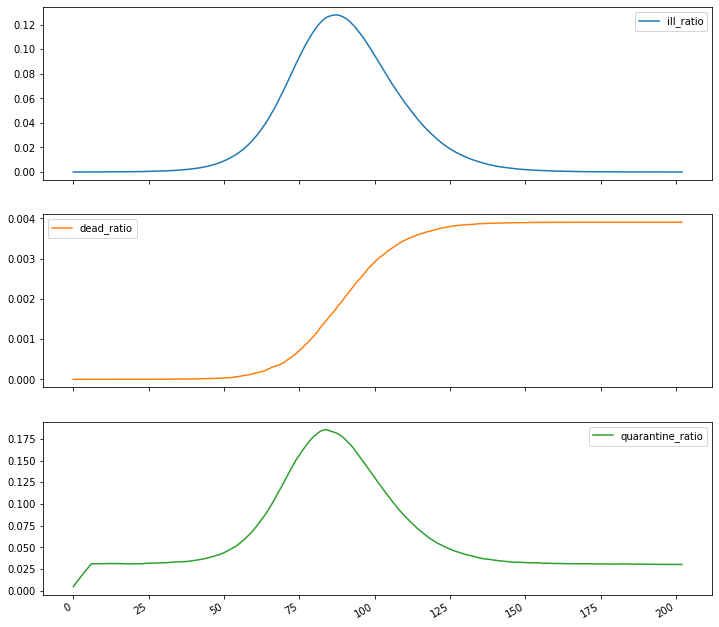

In [23]:
_data, _df = get_ill_dead_ratio_from_spread_model(data_path, 0, 0, 203, slow_unlock=False)
_df.plot(subplots=True, figsize=(12, 12))
ill_ratio_no_lockdown, dead_ratio_no_lockdown, quarantine_ratio_no_lockdown = _data['ill_ratio'], _data['dead_ratio'], _data['quarantine_ratio']

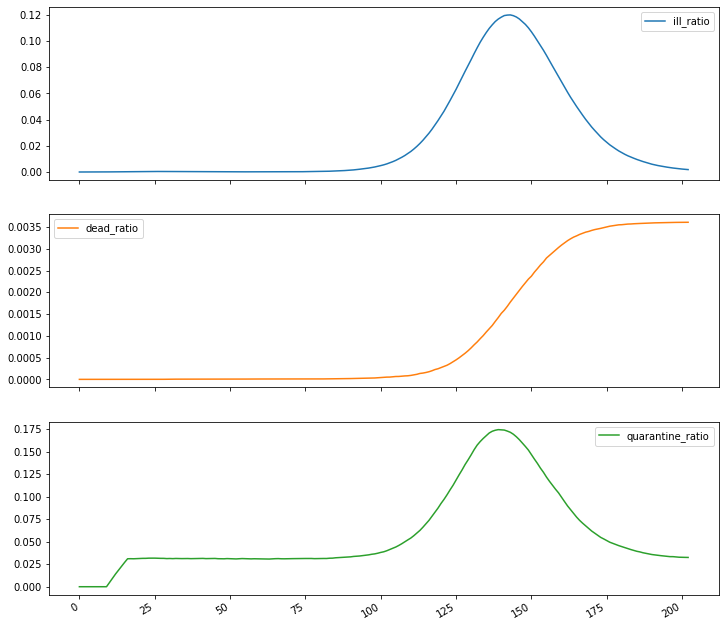

In [24]:
_data, _df = get_ill_dead_ratio_from_spread_model(data_path, 10, 59, 203, slow_unlock=False)
_df.plot(subplots=True, figsize=(12, 12))
ill_ratio_with_lockdown, dead_ratio_with_lockdown, quarantine_ratio_with_lockdown = _data['ill_ratio'], _data['dead_ratio'], _data['quarantine_ratio']

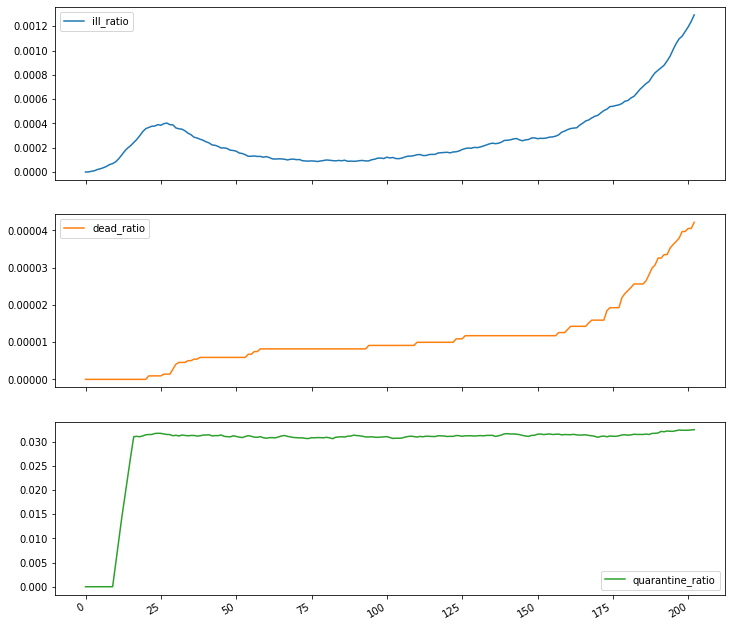

In [27]:
_data, _df = get_ill_dead_ratio_from_spread_model(data_path, 10, 59, 203, slow_unlock=True)
_df.plot(subplots=True, figsize=(12, 12))
ill_ratio_with_slow_lockdown, dead_ratio_with_slow_lockdown, quarantine_ratio_with_slow_lockdown = _data['ill_ratio'], _data['dead_ratio'], _data['quarantine_ratio']

In [11]:
from adapter_covid19.scenarios import BASIC_SCENARIO, BASIC_MODEL_PARAMS

In [20]:
scenarios = { 
    'With Lockdown': Scenario(
        lockdown_start_time=10,
        lockdown_end_time=59,
        furlough_start_time=10,
        furlough_end_time=202,
        simulation_end_time=202,
        new_spending_day=10,
        ccff_day=10,
        loan_guarantee_day=10,
        model_params=BASIC_MODEL_PARAMS,
        ill_ratio=ill_ratio_with_lockdown,
        dead_ratio=dead_ratio_with_lockdown,
        quarantine_ratio=quarantine_ratio_with_lockdown,
    ),
    'No Lockdown': Scenario(
        lockdown_start_time=10000,
        lockdown_end_time=10000,
        furlough_start_time=10000,
        furlough_end_time=10000,
        simulation_end_time=202,
        new_spending_day=10000,
        ccff_day=10000,
        loan_guarantee_day=10000,
        model_params=BASIC_MODEL_PARAMS,
        ill_ratio=ill_ratio_no_lockdown,
        dead_ratio=dead_ratio_no_lockdown,
        quarantine_ratio=quarantine_ratio_no_lockdown,
    ),
}

In [ ]:
result = simulator.simulate_multi(scenarios, show_plots=True, figsize=(5, 15))

Metrics

In [11]:
econ, states = result['10 days only']

In [12]:
from adapter_covid19.metrics import get_quarterly_gdp_decline, get_quarterly_demand_decline

In [13]:
starting_date = pd.Timestamp('2020-03-28').date()

In [14]:
get_quarterly_gdp_decline(starting_date, states)

,GDP decline simulation,GDP decline estimates
2020-03-31,0.999242,0.97
2020-06-30,0.548113,0.75
2020-09-30,NaN,NaN
2020-12-31,NaN,0.86


In [15]:
get_quarterly_demand_decline(starting_date, econ, states)

,Demand decline simulation,Demand decline estimates
2020-03-31,1.000000,0.70
2020-06-30,0.971373,0.55


In [17]:
from adapter_covid19.enums import EmploymentState, Region, Sector, Age

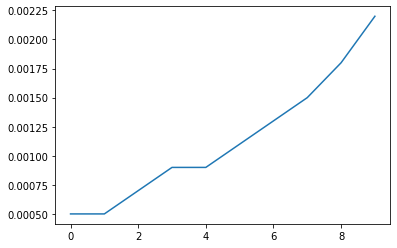

In [19]:
plt.plot([state.ill[(EmploymentState.WFO, Region.C_NE, Sector.A_AGRICULTURE, Age.A18)] for state in states])